# Esperanza's Development Notebook - NEW Version

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import prophet as Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
# Prophet import gives: "Importing plotly failed. Interactive plots will not work."
# Imported everything for Jupyter Notebook and plotly to cooperate but it still isn't

## Comparing Data to New Cleaned Data 

In [2]:
# this path is based on my workflow with virtual environment - path will need to be changed

In [4]:
cleaned_training = pd.read_csv('../final_datasets/training_set_imputed.csv')
cleaned_test = pd.read_csv('../final_datasets/test_set_nonimputed.csv')

In [5]:
cleaned_training.head(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,2017-07-07 13:00:00+00:00,72.0,0.000,74.90,42.735,2.635583,68.22,63.0,75.150,78.890,68.535,63.0,7.022637
1,2017-07-07 14:00:00+00:00,72.0,330.000,74.63,336.490,10.879652,70.56,63.0,74.630,336.490,70.940,63.0,10.975877
2,2017-07-07 15:00:00+00:00,72.0,330.000,73.87,318.140,10.338963,75.44,62.0,73.870,320.615,75.500,62.0,10.261282
3,2017-07-07 16:00:00+00:00,72.0,391.760,74.49,400.855,13.542031,76.25,62.0,74.380,402.760,76.250,62.0,14.572954
4,2017-07-07 17:00:00+00:00,72.0,417.485,74.38,423.900,14.461083,76.69,62.0,74.495,423.900,76.690,62.0,14.362975


In [21]:
cleaned_training.tail(5)

,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
8956,2018-07-15 17:00:00+00:00,72.0,376.020,76.87,377.03,12.517615,76.000,54.0,76.87,377.030,76.13,54.0,12.517615
8957,2018-07-15 18:00:00+00:00,72.0,365.610,76.87,366.19,11.847620,77.130,54.0,76.87,361.050,77.13,54.0,11.847620
8958,2018-07-15 19:00:00+00:00,72.0,324.180,76.87,329.69,10.612003,77.500,54.0,76.87,329.690,77.50,54.0,10.612003
8959,2018-07-15 20:00:00+00:00,72.0,331.790,76.87,333.23,10.598369,77.000,54.0,76.87,327.880,76.94,54.0,10.384728
8960,2018-07-15 21:00:00+00:00,72.0,299.065,75.52,311.47,9.683832,75.595,53.0,75.52,302.005,75.44,53.0,9.861569


In [6]:
training_reduced_prophet = cleaned_training.loc[:, ['time', 'energy']]
test_reduced_prophet = cleaned_test.loc[:, ['time', 'energy']]

In [8]:
training_reduced_prophet = training_reduced_prophet.rename({'time': 'ds', 'energy': 'y'}, axis = 1)
test_reduced_prophet = test_reduced_prophet.rename({'time': 'ds', 'energy': 'y'}, axis = 1)


## Work with Prophet

#### For missing analysis work, please look at old version of this notebook.

In [10]:
# stripping time zones since they're incompatible with Prophet
training_reduced_prophet['ds'] = training_reduced_prophet['ds'].transform(lambda x: x[0:-6])
test_reduced_prophet['ds'] = test_reduced_prophet['ds'].transform(lambda x: x[0:-6])

### Determining cap for Prophet model

In [11]:
training_reduced_prophet['y'].sort_values(ascending = False)

3821    37.321149
3820    36.783517
3823    36.714099
3824    36.225804
3819    36.090618
          ...    
8566     0.000000
8565     0.000000
3379     0.000000
3380     0.000000
8328     0.000000
Name: y, Length: 8961, dtype: float64

In [12]:
training_reduced_prophet['y'].mean()

7.261942517638141

In [13]:
training_reduced_prophet['y'].median()

8.923984893281045

In [14]:
training_reduced_prophet['cap'] = 50
# have not set a changing cap with HVAC because I'm not sure it did change over this time frame

### Training Model

In [15]:
prophet_model = Prophet.Prophet()

In [16]:
prophet_model.fit(training_reduced_prophet)
# got disabling yearly seasonality text - I think this makes sense to disable because our data < year

11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing


### Making Model Forecast

#### We want to predict every 1 hour from August 1, 2018 through the end of the data on January 7, 2019
Doesn't matter so much if we predict too long so long as the periods are right

In [22]:
prophet_forecast = prophet_model.make_future_dataframe(periods = 365 * 24, freq = '1H')
prophet_forecast = prophet_model.predict(prophet_forecast)

In [23]:
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
17716,2019-07-15 17:00:00,8.058932,-29.024072,55.932395,-34.394566,51.624400,5.030430,5.030430,5.030430,4.332805,4.332805,4.332805,0.697626,0.697626,0.697626,0.0,0.0,0.0,13.089363
17717,2019-07-15 18:00:00,8.059042,-28.017007,55.860478,-34.404644,51.643662,5.909694,5.909694,5.909694,5.153607,5.153607,5.153607,0.756087,0.756087,0.756087,0.0,0.0,0.0,13.968735
17718,2019-07-15 19:00:00,8.059151,-27.110214,58.426507,-34.414722,51.662925,6.723980,6.723980,6.723980,5.916787,5.916787,5.916787,0.807193,0.807193,0.807193,0.0,0.0,0.0,14.783132
17719,2019-07-15 20:00:00,8.059261,-27.403901,58.569212,-34.424800,51.674747,7.220648,7.220648,7.220648,6.369622,6.369622,6.369622,0.851025,0.851025,0.851025,0.0,0.0,0.0,15.279908
17720,2019-07-15 21:00:00,8.059371,-26.352738,58.357212,-34.434878,51.682841,6.955785,6.955785,6.955785,6.068057,6.068057,6.068057,0.887728,0.887728,0.887728,0.0,0.0,0.0,15.015156


In [ ]:
# This got us a little past the time I wanted to be at but it works

## Plot Analysis

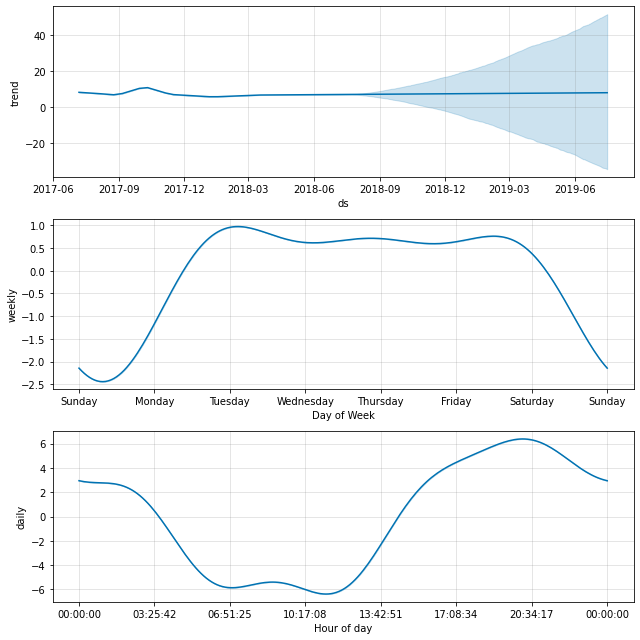

In [24]:
fig2 = prophet_model.plot_components(prophet_forecast)

In [ ]:
# These figures look almost the same as the ones without imputation

## Finding MSE

In [25]:
prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]

In [29]:
prophet_forecast['ds'].head(5)

0   2017-07-07 13:00:00
1   2017-07-07 14:00:00
2   2017-07-07 15:00:00
3   2017-07-07 16:00:00
4   2017-07-07 17:00:00
Name: ds, dtype: datetime64[ns]

In [31]:
test_reduced_prophet['ds'] = pd.to_datetime(test_reduced_prophet['ds'])

In [33]:
merged = prophet_forecast_reduced.merge(test_reduced_prophet, left_on = 'ds', right_on = 'ds')

In [34]:
merged.shape

(188633, 3)

In [35]:
test_reduced_prophet.shape

(188633, 2)

In [39]:
sum((merged['y'] - merged['yhat']) ** 2) / test_reduced_prophet.shape[0]

47.084880519281775

This gives an MSE of 47:
- Floor 2 original 5-min floored was: 50.64062665397791
- Floor 3 original 5-min floored was: 47.75016453897674
- Floor 4 original 5-min floored was 274.2433927796554

This is an improvement across the board and a more consistent predictor but still not low
Try and see if we can improve it via parameters to use as a baseline.

# Attempt(s) 2: no cap and different parameters for changepoint_prior_scale

In [42]:
training_reduced_prophet = training_reduced_prophet.drop(['cap'], axis = 1)

In [43]:
flexibility_values = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

In [44]:
mses = []

In [45]:
for val in flexibility_values:
    prophet_model = Prophet.Prophet(changepoint_prior_scale=val)
    prophet_model.fit(training_reduced_prophet)
    
    prophet_forecast = prophet_model.make_future_dataframe(periods = 365 * 24, freq = '1H')
    prophet_forecast = prophet_model.predict(prophet_forecast)

    prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]
    merged = prophet_forecast_reduced.merge(test_reduced_prophet, left_on = 'ds', right_on = 'ds')
    
    mses.append(sum((merged['y'] - merged['yhat']) ** 2) / test_reduced_prophet.shape[0])
    

12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing
12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
mses

[46.45772364455673,
 46.48577549176039,
 46.610635515273714,
 46.89409649782326,
 47.084880519281775,
 46.47556825295931,
 46.756375060866304,
 52.33694940728566]

In [ ]:
# MSE is lowest at 1, 0.01, 0.5 but still in a similar range as the original value so not substantial improvements

# Attempt(s) 3: cap values with 1 for flexibility

In [47]:
cap_values = [10,20,30,40,50,60,70,80,90,100]

In [48]:
mses = []

In [58]:
for val in cap_values:
    training_reduced_prophet.loc[:, 'cap'] = val
    
    prophet_model = Prophet.Prophet(changepoint_prior_scale=1)
    prophet_model.fit(training_reduced_prophet)
    
    prophet_forecast = prophet_model.make_future_dataframe(periods = 365 * 24, freq = '1H')
    prophet_forecast = prophet_model.predict(prophet_forecast)

    prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]
    merged = prophet_forecast_reduced.merge(test_reduced_prophet, left_on = 'ds', right_on = 'ds')
    
    mses.append(sum((merged['y'] - merged['yhat']) ** 2) / test_reduced_prophet.shape[0])
    

13:04:47 - cmdstanpy - INFO - Chain [1] start processing
13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] start processing
13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing
13:05:05 - cmdstanpy - INFO - Chain [1] done processing
13:05:08 - cmdstanpy - INFO - Chain [1] start processing
13:05:10 - cmdstanpy - INFO - Chain [1] done processing
13:05:13 - cmdstanpy - INFO - Chain [1] start processing
13:05:15 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing
13:05:21 - cmdstanpy - INFO - Chain [1] done processing
13:05:24 - cmdstanpy - INFO - Chain [1] start processing
13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:29 - cmdstanpy - INFO - Chain [1] start processing
13:05:31 - cmdstanpy - INFO - Chain [1]

In [59]:
mses

[46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673,
 46.45772364455673]

In [ ]:
# Cap value: no impact

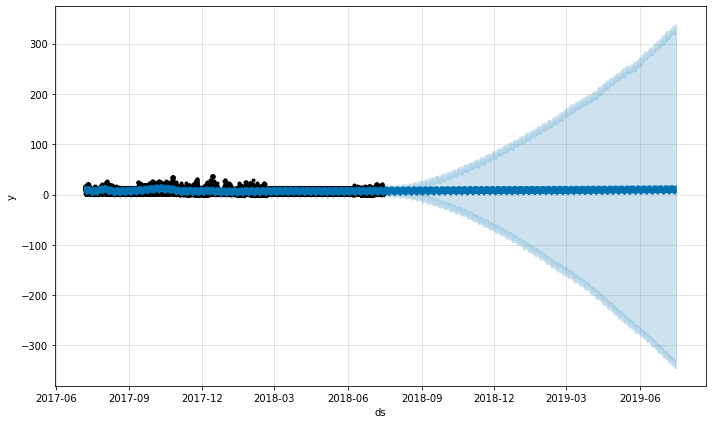

In [60]:
fig = prophet_model.plot(prophet_forecast)

In [ ]:
# This is how the forecas tfits - it's having a difficult time predicting the range, which it thinks expands dramatically

# or are those just the upper and lower possible trends?

# Attempt 4 - Accounting for Days on Break

In [61]:
def is_school_break(ds):
    date = pd.to_datetime(ds)
    #https://blink.ucsd.edu/instructors/resources/academic/calendars/2016.html
    #https://blink.ucsd.edu/instructors/resources/academic/calendars/2017.html
    #https://blink.ucsd.edu/instructors/resources/academic/calendars/2018.html
    date_ranges = [
        ['03/26/2017', '04/06/2017'], 
        ['06/17/2017', '07/02/2017'],
        ['09/10/2017', '09/24/2017'],
        ['12/17/2017', '01/02/2018'],
        ['03/25/2018', '04/01/2018'],
        ['06/16/2018', '07/01/2018'],
        ['09/09/2018', '09/23/2018'],
        ['12/16/2018', '01/06/2019']
    ]
    
    for date_range in date_ranges:
        if pd.to_datetime(date_range[0]) <= date and pd.to_datetime(date_range[1]) >= date:
            return True
    return False

In [62]:
training_reduced_prophet = training_reduced_prophet.loc[:, ['ds', 'y']]


training_reduced_prophet['on_season'] = training_reduced_prophet['ds'].apply(is_school_break)
training_reduced_prophet['off_season'] = ~training_reduced_prophet['ds'].apply(is_school_break)

In [69]:
test_reduced_prophet['on_season'] = test_reduced_prophet['ds'].apply(is_school_break)
test_reduced_prophet['off_season'] = ~test_reduced_prophet['ds'].apply(is_school_break)

In [ ]:
# this is taking a while to run

In [71]:
training_reduced_prophet.head(5)

,ds,y,on_season,off_season
0,2017-07-07 13:00:00,2.635583,False,True
1,2017-07-07 14:00:00,10.879652,False,True
2,2017-07-07 15:00:00,10.338963,False,True
3,2017-07-07 16:00:00,13.542031,False,True
4,2017-07-07 17:00:00,14.461083,False,True


In [72]:
test_reduced_prophet.head(5)

,ds,y,on_season,off_season
0,2018-09-03 01:00:00,9.038064,False,True
1,2018-09-03 01:00:00,9.020124,False,True
2,2018-09-03 01:00:00,8.966305,False,True
3,2018-09-03 01:00:00,9.121355,False,True
4,2018-09-03 01:00:00,8.978479,False,True


In [70]:
prophet_model = Prophet.Prophet(changepoint_prior_scale=1)
prophet_model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
prophet_model.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')


prophet_model.fit(training_reduced_prophet)
    
prophet_forecast = prophet_model.make_future_dataframe(periods = 365 * 24, freq = '1H')
prophet_forecast = prophet_model.predict(prophet_forecast)

prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]
merged = prophet_forecast_reduced.merge(test_reduced_prophet, left_on = 'ds', right_on = 'ds')
    
sum((merged['y'] - merged['yhat']) ** 2) / test_reduced_prophet.shape[0]

13:16:22 - cmdstanpy - INFO - Chain [1] start processing
13:16:26 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Condition 'on_season' missing from dataframe

In [ ]:
# this had no impact on reducing MSE